In [47]:
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_datasets as tfds
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define data augmentation
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
], name='data_augmentation')

# Load the EMNIST dataset
builder = tfds.builder('emnist/byclass')
builder.download_and_prepare()
datasets = builder.as_dataset(as_supervised=True)
train_dataset, test_dataset = datasets['train'], datasets['test']

# Updated preprocessing function to normalize, reshape, and correct the orientation of images
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.rot90(img, k=-1)
    img = tf.image.flip_left_right(img)
    img = tf.expand_dims(img, -1)
    return img, label

# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Batch and prefetch the dataset for performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model definition with data augmentation
model = models.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    data_augmentation,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(62, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.summary()

Num GPUs Available:  0
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 28, 28, 1)         0         
 ial)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_41 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_74 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                              

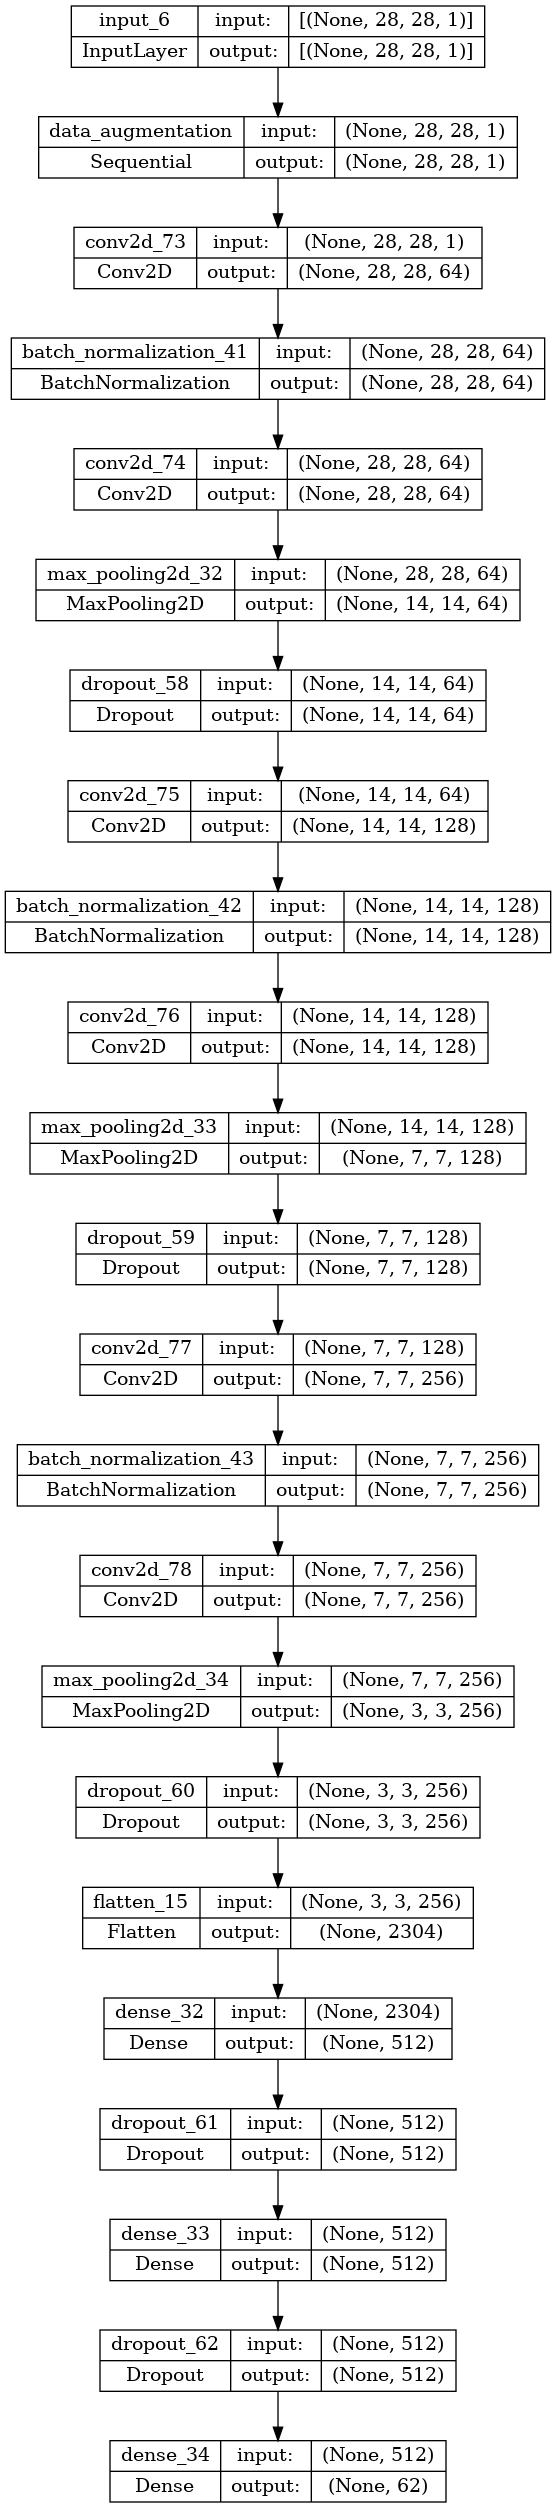

In [48]:
from tensorflow.keras.utils import plot_model

# Generate a plot of the model architecture-
plot_model(model, to_file='web/img/model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [49]:
# Ouput the number of images in the training set
print("Number of training images: ", builder.info.splits['train'].num_examples)
print("Number of test images: ", builder.info.splits['test'].num_examples)

Number of training images:  697932
Number of test images:  116323


In [50]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=test_dataset,
                    callbacks=[reduce_lr])

Epoch 1/20
  500/21811 [..............................] - ETA: 20:11 - loss: 3.7805 - accuracy: 0.0710

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nTest accuracy: {test_acc}')

In [ ]:
model.save('models/emnist_cnn_savedmodel')

!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='softmax_tensor' models/emnist_cnn_savedmodel web/models/emnist_cnn_tfjs

In [ ]:
# import tensorflow as tf
# import numpy as np

# # Load the image file
# image_path = '4.png'
# image_string = tf.io.read_file(image_path)

# # Decode the image, convert it to grayscale, and resize it
# img = tf.image.decode_image(image_string, channels=1)
# img = tf.image.resize(img, [28, 28])

# # Normalize the pixel values
# img_array = img / 255.0

# # Expand dimensions to fit the model input shape (1, 28, 28, 1)
# img_array = np.expand_dims(img_array, axis=0)

# # Make a prediction
# predictions = model.predict(img_array)

# # Get the predicted label
# predicted_label = np.argmax(predictions)

# print(f'Predicted label: {predicted_label}')